In [22]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import re
import nltk
from wordcloud import WordCloud
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss, precision_score
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!ls "drive/MyDrive/Colab Notebooks/TripAdvisorHotelReviews"

tripadvisor_hotel_reviews.csv  TripAdvisor.ipynb


In [25]:
# defining data path
datadir="drive/MyDrive/Colab Notebooks/TripAdvisorHotelReviews/"


In [26]:
reviews = pd.read_csv(f'{datadir}/tripadvisor_hotel_reviews.csv')

In [27]:
reviews.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [28]:
reviews.shape

(20491, 2)

In [29]:
print(reviews["Review"][0])

nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  


In [30]:
print(reviews["Review"][5])

love monaco staff husband stayed hotel crazy weekend attending memorial service best friend husband celebrating 12th wedding anniversary, talk mixed emotions, booked suite hotel monte carlos, loaned beautiful fan-tanned goldfish named joliet weekend visited dogs worked desk human companions, room decorated nicely couch used pillows, l'occitane bath amenities welcome sight, room quiet peaceful, wireless internet access wonderful server went morning leaving problems printing boarding passes, afternoon reception serves oenophile-satisfying wine australia scrumptious cookies, restaurant closed renovation stay finally ate food good drinks better, word caution restaurant larger person not sit booths wo n't fit, 5'6 125 lbs husband 5'9 175. table smack-against stomach couple inches space mighty uncomfortable patron larger pregnant, bad design opinion place decorated funky welcoming way metal wood handblown glass light fixtures expect seattle capital glass art industry, definitely stay reason,

In [31]:
#  Review count in each category rating 
a = reviews.groupby(by='Rating')['Review'].count()
a

Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: Review, dtype: int64

<BarContainer object of 5 artists>

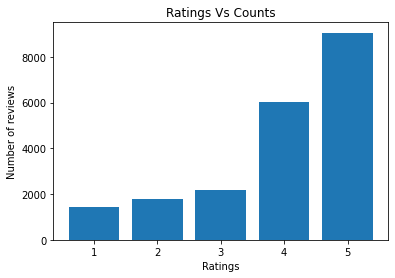

In [32]:

plt.title('Ratings Vs Counts')
plt.xlabel('Ratings')
plt.ylabel('Number of reviews')

plt.bar(a.index,a.values)


In [33]:
reviews["Review"] = reviews["Review"].str.lower()
reviews["Review"] = reviews["Review"].str.replace('\d+', '')

Word cloud to see most important words in the dataset

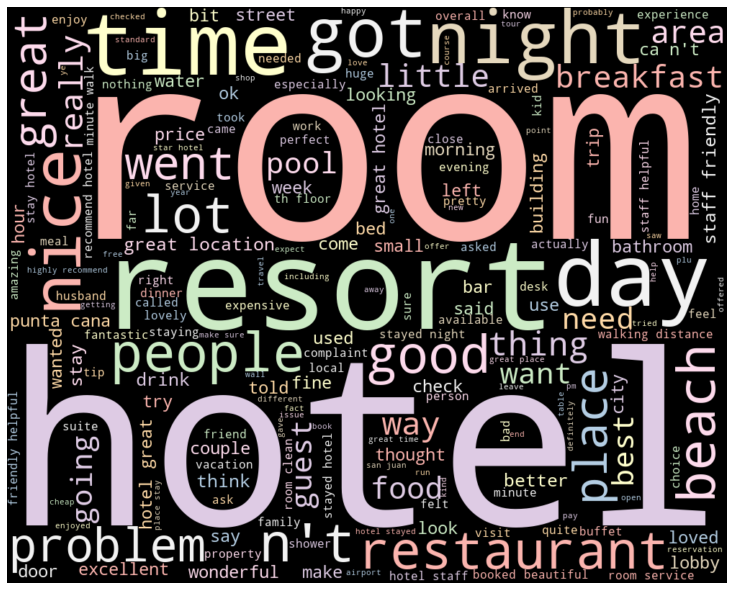

In [34]:
wordcloud = WordCloud(width = 1000, height = 800, random_state=1,background_color='black', 
                      colormap='Pastel1').generate(" ".join(reviews["Review"]))

plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [35]:
# bag of words
count_vectorizer = CountVectorizer(max_features=500, analyzer='word', stop_words = 'english')
vector_model = count_vectorizer.fit_transform(reviews['Review']).toarray()
print(vector_model)
print(vector_model.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 2 0]]
(20491, 500)


In [36]:
print("Top {} the most used word by reviewers: {}".format(500, count_vectorizer.get_feature_names()))

Top 500 the most used word by reviewers: ['able', 'absolutely', 'access', 'activities', 'actually', 'afternoon', 'air', 'airport', 'amazing', 'amenities', 'american', 'amsterdam', 'area', 'areas', 'arrival', 'arrived', 'ask', 'asked', 'ate', 'available', 'average', 'away', 'awesome', 'bad', 'bags', 'balcony', 'bar', 'barcelona', 'bars', 'bath', 'bathroom', 'bathrooms', 'beach', 'beautiful', 'bed', 'bedroom', 'beds', 'beer', 'believe', 'best', 'better', 'big', 'bit', 'block', 'blocks', 'book', 'booked', 'booking', 'bottle', 'breakfast', 'bring', 'brought', 'buffet', 'building', 'bus', 'business', 'busy', 'buy', 'ca', 'cafe', 'called', 'came', 'cana', 'car', 'card', 'care', 'casino', 'center', 'central', 'centre', 'certainly', 'chairs', 'change', 'charge', 'cheap', 'check', 'checked', 'children', 'choice', 'choose', 'chose', 'city', 'clean', 'cleaned', 'close', 'club', 'coffee', 'cold', 'come', 'comfortable', 'coming', 'complaint', 'complimentary', 'concierge', 'convenient', 'cool', 'cor

In [37]:
# extracting words:

data=pd.DataFrame(count_vectorizer.get_feature_names(),columns=["Words"])
data.head()

,Words
0,able
1,absolutely
2,access
3,activities
4,actually


Wordclould after extractiong most meaningful words



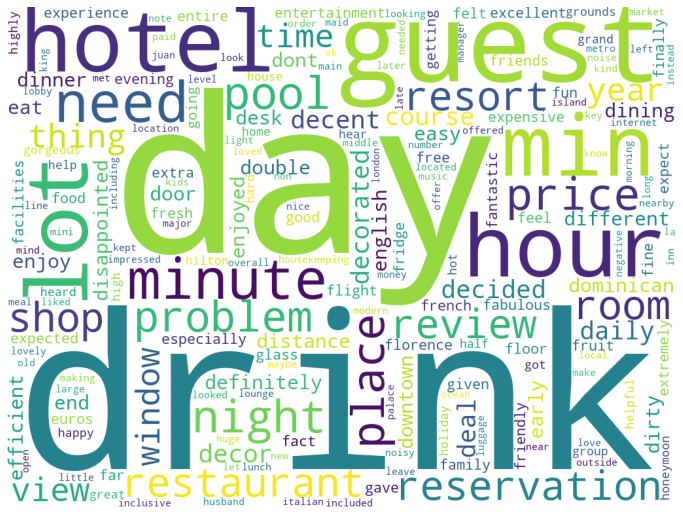

In [38]:
plt.subplots(figsize=(12,12))
wordcloud=WordCloud(background_color="white",width=1024,height=768).generate(" ".join(data.Words[100:]))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Split data into test and training


In [39]:
from imblearn.over_sampling import SMOTE 
X = vector_model
y = reviews['Rating']

sm = SMOTE(random_state = 2) 
X_smote, y_smote = sm.fit_sample(X, y) 

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [40]:
from sklearn.ensemble import RandomForestClassifier


rf_model=RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [41]:
y_pred=rf_model.predict(X_test)
y_pred

array([2, 3, 3, ..., 1, 4, 4])

In [42]:

print(f'Confusion Matrix \n {confusion_matrix(y_test, y_pred)}')
print("Accuracy with P-R scores and F-score")
print(classification_report(y_test, y_pred))
print()

Confusion Matrix 
 [[1623   87   51   30   16]
 [ 119 1416  120  105   75]
 [  60   90 1378  191   92]
 [  24   61  157  995  558]
 [  17   25   26  387 1351]]
Accuracy with P-R scores and F-score
              precision    recall  f1-score   support

           1       0.88      0.90      0.89      1807
           2       0.84      0.77      0.81      1835
           3       0.80      0.76      0.78      1811
           4       0.58      0.55      0.57      1795
           5       0.65      0.75      0.69      1806

    accuracy                           0.75      9054
   macro avg       0.75      0.75      0.75      9054
weighted avg       0.75      0.75      0.75      9054




In [43]:
X = vector_model
y = reviews['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)
print(X_test)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [44]:
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import SpatialDropout1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional


model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=20491,
                    output_dim=500,
                    input_length=500))


model.add(LSTM(100))
model.add(Dense(500, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 500)          10245500  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               240400    
_________________________________________________________________
dense (Dense)                (None, 500)               50500     
Total params: 10,536,400
Trainable params: 10,536,400
Non-trainable params: 0
_________________________________________________________________


In [45]:
history_lstm = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data= (X_test, y_test), shuffle= False)


Epoch 1/10
513/513 [==============================] - 80s 140ms/step - loss: 1.9622 - accuracy: 0.4291 - val_loss: 1.3610 - val_accuracy: 0.4418
Epoch 2/10
513/513 [==============================] - 71s 139ms/step - loss: 1.3664 - accuracy: 0.4395 - val_loss: 1.3592 - val_accuracy: 0.4418
Epoch 3/10
513/513 [==============================] - 71s 139ms/step - loss: 1.3642 - accuracy: 0.4392 - val_loss: 1.3585 - val_accuracy: 0.4418
Epoch 4/10
513/513 [==============================] - 72s 140ms/step - loss: 1.3637 - accuracy: 0.4392 - val_loss: 1.3582 - val_accuracy: 0.4418
Epoch 5/10
513/513 [==============================] - 71s 139ms/step - loss: 1.3635 - accuracy: 0.4391 - val_loss: 1.3581 - val_accuracy: 0.4418
Epoch 6/10
513/513 [==============================] - 71s 139ms/step - loss: 1.3634 - accuracy: 0.4392 - val_loss: 1.3580 - val_accuracy: 0.4418
Epoch 7/10
513/513 [==============================] - 71s 139ms/step - loss: 1.3633 - accuracy: 0.4392 - val_loss: 1.3580 - val_ac

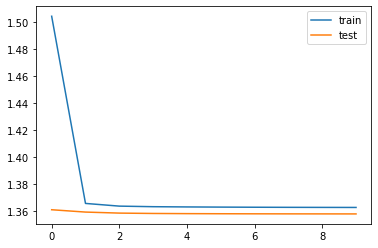

In [46]:
plt.plot(history_lstm.history['loss'], label = 'train')
plt.plot(history_lstm.history['val_loss'], label = 'test')
plt.legend()
plt.show()

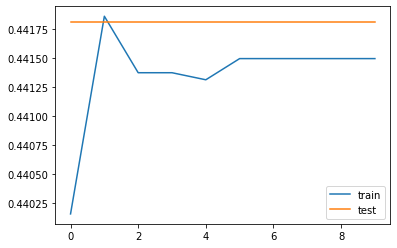

In [47]:
plt.plot(history_lstm.history['accuracy'], label = 'train')
plt.plot(history_lstm.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [48]:

from sklearn.svm import SVC
no_of_features = 5
svclassifier = SVC(kernel= 'rbf', gamma = 'auto', verbose = True, random_state=42 )

In [49]:
svclassifier.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=True)

In [50]:
y_pred = svclassifier.predict(X_test)


In [51]:
print(f'Confusion Matrix \n {confusion_matrix(y_test, y_pred)}')
print("Accuracy with P-R scores and F-score")
print(classification_report(y_test, y_pred))
print()

Confusion Matrix 
 [[ 158   66    2   15   43]
 [  66  109   26   83   75]
 [  17   60   26  247   87]
 [   7   18   12  597  574]
 [   1    4    1  253 1552]]
Accuracy with P-R scores and F-score
              precision    recall  f1-score   support

           1       0.63      0.56      0.59       284
           2       0.42      0.30      0.35       359
           3       0.39      0.06      0.10       437
           4       0.50      0.49      0.50      1208
           5       0.67      0.86      0.75      1811

    accuracy                           0.60      4099
   macro avg       0.52      0.45      0.46      4099
weighted avg       0.56      0.60      0.56      4099


